# Discrete Logarithm

> The **Discrete Logarithm Problem** [[1](#DiscreteLog)] was shown by Shor [[2](#Shor)] to be solved in a polynomial time using quantum computers, while the fastest classical algorithms take a superpolynomial time. The problem is at least as hard as the factoring problem. In fact, the hardness of the problem is the basis for the Diffie-Hellman [[3](#DiffieHellman)] protocol for key exchange. The algorithm is a specific instance of the Abelian Hidden Subgroup Problem [[4](#HSP)].
> 
> The algorithm treats the following problem:
> 
> - **Input:** A cyclic group $G = \langle g \rangle$ with a generator $g\in G$, an element $x\in G$ and the order of the group is known $r=|G|$. A quantum oracle $U_f$ applying the transformation $$U_f|\alpha\rangle |\beta\rangle |0\rangle = |\alpha\rangle |\beta\rangle |f(\alpha, \beta)\rangle~~,$$ where $f(\alpha, \beta) = x^\alpha g^\beta$ with $\alpha, \beta \in \mathbb{Z}_r$.
> - **Promise:**  There is a positive integer $s\in \mathbb{N}$ such that $g^s = x$.
> - **Output:** The least positive integer $s = \log_g x$, i.e, the discrete logarithm.
> 
> - **Complexity:** A single application of the algorithm succeeds with probability $O(\log \log r)$ and requires $O((\log t)^2)$ time, where $t = \lceil \log r +\log(1/\epsilon) \rceil$ and $1-\epsilon$ is success probability. Hence, boosting the success probability to a constant $O(1)$ via repetition yields a total expected runtime of $$O((\log t)^2 \log \log r)~.$$
>
> ---
>
> **Keywords:** Abelain Hidden subgroup problem, quantum Fourier transform, period finding.

## Algorithm Steps
We first consider the case where $r=2^m$ and later generalize. 
We begin by introducing an input state $$|\psi_0\rangle = |0^m\rangle|0^m\rangle|0^R\rangle~~,$$ where $R$ is the number of bits required to represent $f$'s image. In addition, we note that $f(\alpha,\beta) = x^\alpha g^\beta = g^{\alpha\log_g x + \beta}$ is constant on lines satisfying  $$\{(\alpha,\beta)\in \mathbb{Z}_r^2, \alpha\log_g x + \beta = \lambda \mod r\}~.$$


The algorithm includes four main steps, and has a similar structure to the other quantum algorithms for the hidden subgroup problem.
1. We first prepare a uniform superposition over the input states of the first two registers:
$$ |0^m\rangle|0^m\rangle|0^m\rangle  \xrightarrow{H^{\otimes m}} \frac{1}{r}\sum_{\alpha,\beta \in \mathbb{Z}_r}|\alpha \rangle |\beta \rangle |0^m\rangle ~~.$$ 
2. Perform a query to the oracle $$ \xrightarrow{U_f} \frac{1}{r}\sum_{\alpha, \beta \in \mathbb{Z}_r}|\alpha \rangle |\beta \rangle |f(\alpha, \beta)\rangle~~.$$ Utilizing the periodicity of $f$, we can express the state as $$ = \frac{1}{r}\sum_{\alpha, \lambda \in \mathbb{Z}_r}|\alpha \rangle |\lambda -\alpha \log_g x \rangle |g^{\lambda}\rangle~~.  $$
3. Perform a double inverse Fourier transform over the group $\mathbb{Z}_r$ $$\xrightarrow{\text{QFT}_{\mathbb{Z}_r}^\dagger \times \text{QFT}_{\mathbb{Z}_r}^\dagger } \frac{1}{r^2}\sum_{\lambda, \mu, \nu \in \mathbb{Z}_r}\left(\sum_\alpha e^{-i 2\pi \alpha(\mu - \nu \log_g x)/r}\right)e^{-i 2\pi \lambda \nu/r}|\mu \rangle |\nu \rangle |g^{\lambda}\rangle$$  $$ = \frac{1}{r}\sum_{\lambda, \nu \in \mathbb{Z}_r}e^{i 2\pi \lambda \nu/r}|\nu \log_g x \rangle |\nu \rangle |g^{\lambda}\rangle~~, $$where the Fourier transform over $\mathbb{Z}_r$ is $\text{QFT}_{\mathbb{Z}_r} |\alpha \rangle = \frac{1}{\sqrt{r}}\sum_{\mu\in \mathbb{Z}_r} e^{i 2\pi \alpha \mu/r}|\mu \rangle$ and in the second line we utilized the identity $\sum_\alpha e^{i 2\pi \alpha \eta} = r \delta_{0\eta}$ (easily derived by use of a sum over a geometric series). 
4. Measure the three quantum variables. The measurement of the third variable collapses the quantum state to $|g^\lambda \rangle$ with a uniform distribution. After the collapse, the resulting state is independent of $\lambda$, therefore, we can discard this measurement outcome. From the measurement of the second quantum variable, we obtain with a uniform distribution over $\nu$ the outcome $\nu \log_g x$. With a probablility of order $O(\log \log r)$, the obtained result $\nu$ is co-prime to $r$, and there exists a modular $r$ multiplicative inverse $\nu^{-1}$. Under this condition, we can multiply the outcome of the second register to obtain the discrete log $s=\log_g x$. Hence, repeating the experiment $O(\log \log r)$ times leads to a success probability of order $O(1)$. 

## Building the Algorithm with Classiq

We begin by importing software packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from classiq import *
from classiq.qmod.symbolic import ceiling, log

We consider two exemplary cases. First, we study the group $\mathbb{Z}_5^\times$, where the order is a power of $r=4=2^2$. For this case, quantum variables with only $\log r = m$ qubits are required. Following, the group $\mathbb{Z}_{13}^\times$ exemplifies the alternative case where the order $ r\neq 2^m$ for an integer $m$. 

For these examples, we denote the modulus by $N$. Since, these are cyclic groups, we have $N = r+1$, therefore $R = \lceil \log N\rceil$. In the following examples, the third register, containing the function $f(\alpha, \beta )$ after the second step, is represented by $\lceil \log N\rceil$.

The heart of the algorithm's logic is the implementation of the function
$$
|\alpha \rangle|\beta \rangle|0\rangle \rightarrow |\alpha \rangle|\beta \rangle|x^{\alpha } g^{\beta}\rangle~. 
$$

This is done using two applications of the modular exponentiation function, described in detail in the [Shor's Factoring Algorithm](https://short.classiq.io/shor) notebook. So here we import it from the Classiq library.

The `modular_exponentiation` function defined below accepts these arguments:
- `N: CInt` - modulo number
- `a: CInt` - base of the exponentiation
- `x: QArray[QBit]` - unsigned integer to multiply by the exponentiation
- `pw: QArray[QBit]`- power of the exponentiation

So the function implements 
$|pw\rangle|x\rangle \rightarrow |pw\rangle|x \cdot a ^ {pw}\mod N\rangle$.

In [2]:
from classiq import *


@qfunc
def modular_exponentiation(N: CInt, a: CInt, x: QArray, pw: QArray):
    repeat(
        count=pw.len,
        iteration=lambda index: control(
            pw[index],
            # lambda: inplace_modular_multiply(N, (a ** (2**index)) % N, x),  #modular_multiply_constant_inplace
            lambda: modular_multiply_constant_inplace(N, a ** (2**index), x),
        ),
    )


@qfunc
def discrete_log_oracle(
    g_generator: CInt,
    x_element: CInt,
    N_modulus: CInt,
    alpha: QArray,
    beta: QArray,
    func_res: Output[QNum],
) -> None:
    allocate(ceiling(log(N_modulus, 2)), func_res)

    func_res ^= 1
    modular_exponentiation(N_modulus, x_element, func_res, alpha)
    modular_exponentiation(N_modulus, g_generator, func_res, beta)

### Full Algorithm
1. Prepare a uniform superposition over the first two quantum variables `alpha`, `beta`. Each variable has size $\lceil \log r\rceil + \log({1/{\epsilon}})$. In the special case where $r$ is a power of 2,  $\log r$ is enough.
3. Compute `discrete_log_oracle` on the `func_res` variable. `func_res` is of size $\lceil \log N\rceil$.
4. Apply the inverse Fourier transform `alpha`, `beta`.
5. Measure.

In [3]:
@qfunc
def discrete_log(
    g: CInt,
    x: CInt,
    N: CInt,
    order: CInt,
    alpha: Output[QArray],
    beta: Output[QArray],
    func_res: Output[QArray],
) -> None:
    reg_len = ceiling(log(order, 2))
    allocate(reg_len, alpha)
    allocate(reg_len, beta)

    hadamard_transform(alpha)
    hadamard_transform(beta)

    discrete_log_oracle(g, x, N, alpha, beta, func_res)

    invert(lambda: qft(alpha))
    invert(lambda: qft(beta))

After the inverse QFTs (under the assumption of $r=2^m$ for some $m$, therefore $t=2^r$), the variables become
$$  |\psi\rangle = \frac{1}{r}\sum_{\lambda, \nu \in \mathbb{Z}_r}e^{i 2\pi \lambda \nu/r}|\nu \log_g x \rangle_{\alpha} |\nu \rangle_{\beta} |g^{\lambda}\rangle_{\text{res}}$$
where we added a subscript to the quantum variables for clarity, and $| \rangle_{\text{res}}$ designates the `func_res` variable. 


If $\nu\in \mathbb{Z}_r$ has an inverse, $\nu^{-1}\in\mathbb{Z}_r$ we can extract  $s=\log_x g$ from variable $\alpha$ by multiplying by $\nu^{-1}$. See the second example for the general case, for which $r \neq 2^m$.

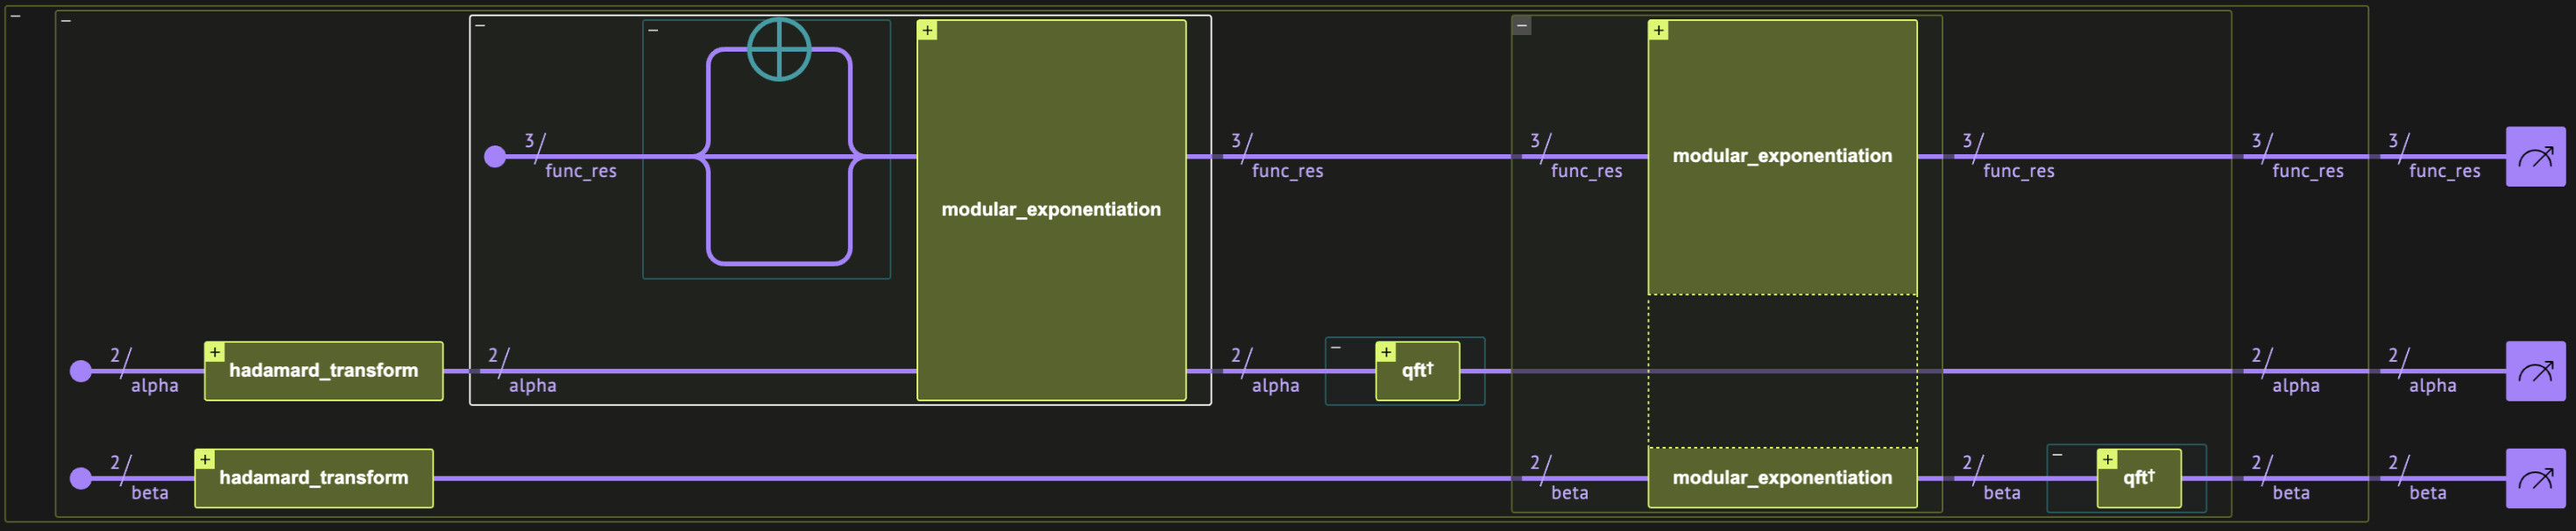

## Example:  $G = \mathbb{Z}_5^\times$

For this specific demonstration, we choose $G = \mathbb{Z}_5^\times$, with $g=3$ and $x=2$. With this setting, $\log_gx=3$.

We choose this specific example because the order of the group $r=4$ is a power of $2$, so we can get the exact discrete logarithm without continued-fractions postprocessing. In other cases, we use a larger quantum variable for the exponents so the continued fractions postprocessing converges.

In [4]:
MODULU_NUM = 5
G_GENERATOR = 3
X_LOG_ARG = 2
ORDER = MODULU_NUM - 1  # as 5 is prime


@qfunc
def main(
    alpha: Output[QNum],
    beta: Output[QNum],
    func_res: Output[QNum],
) -> None:
    discrete_log(G_GENERATOR, X_LOG_ARG, MODULU_NUM, ORDER, alpha, beta, func_res)

In [5]:
qmod_Z5 = create_model(
    main,
    constraints=Constraints(max_width=13),
    preferences=Preferences(optimization_level=1),
    execution_preferences=ExecutionPreferences(num_shots=4000),
    out_file="discrete_log",
)

qprog_Z5 = synthesize(qmod_Z5)
show(qprog_Z5)

Quantum program link: https://platform.classiq.io/circuit/36zUExgS7ndoE6IUFudD7cLnNii


In [6]:
result_Z5 = execute(qprog_Z5).result_value()
result_Z5.dataframe

,alpha,beta,func_res,count,probability,bitstring
0,2,2,3,268,0.06700,0111010
1,2,2,2,266,0.06650,0101010
2,0,0,3,266,0.06650,0110000
3,0,0,1,264,0.06600,0010000
4,3,1,1,259,0.06475,0010111
5,2,2,1,258,0.06450,0011010
6,1,3,3,256,0.06400,0111101
7,1,3,1,250,0.06250,0011101
8,1,3,4,250,0.06250,1001101
9,3,1,3,246,0.06150,0110111


Note that `func_res` is uncorrelated to the other variables, and we get uniform distribution, as expected. 

We take only the `beta` that are co-prime to $r=4$, so they have a multiplicative-inverse. Hence `beta=1,3` are the relevant results.
So we get two relevant results (for all different $\lambda$s): $|1\rangle|3\rangle$, $|3\rangle|1\rangle$. All that remains to get the logarithm is to multiply `alpha` by the inverse of `beta`:

In [7]:
for res in result_Z5.parsed_counts:
    if res.state["beta"] in [1, 3]:
        logarithm = res.state["beta"] * pow(res.state["alpha"], -1, 4)
        assert logarithm == 3

Verify we received the correct discrete logarithm:

In [8]:
log_arg = (G_GENERATOR**logarithm) % MODULU_NUM
print(log_arg)
assert log_arg == X_LOG_ARG

2


And, indeed, both cases give the same result, which is exactly the discrete logarithm: $\log_32 \mod 5 = 3$.

## Generalization for the case where $r\neq 2^m$

For an arbitrary $r\in \mathbb{N}$, we employ two $t=\lceil \log r\rceil + \log (1/\epsilon)$ qubit quantum variables and a third $R$-qubit register, initialized to the state $|\psi_0\rangle = |0^t\rangle|0^t\rangle|0^R\rangle $, where $R = \lceil \log N\rceil$. The derivation follows a similar structure, where the initial sums are now $\alpha, \beta \in \mathbb Z_T$, with $T=2^t$, while the period of $f$ remains $r$, i.e., $\lambda\in \mathbb{Z}_r$. Therefore, after the second step we obtain the state $$\frac{1}{T}\sum_{\alpha,\beta \in \mathbb{Z}_T}|\alpha\rangle|\beta\rangle|0^R\rangle\xrightarrow{U_f}  \frac{1}{T}\sum_{\alpha,\beta\in \mathbb{Z}_T}|\alpha \rangle |\beta\rangle |g^{\alpha \log_g x + \beta}\rangle~~.$$

Next, we express the periodic state in an alternative form. We introduce the operator $U_g$, which satisfies $U_g |h\rangle= |h g\rangle$, where $e$ is the identity element of the group. Therefore $|{g^\lambda}\rangle = U_g^\lambda |e \rangle$. The state $|e\rangle$ can be expressed as a uniform superposition of  the eigenstates of $U_g$:
$$|e \rangle = \frac{1}{\sqrt{r}}\sum_{k=0}^{r-1} |\Psi_k\rangle~~,$$ where $| \Psi_k \rangle = \frac{1}{\sqrt{r}} \sum_{k=0}^{r-1} e^{i2\pi k k'/r}| g^{k'}\rangle$, which satisfy $U_g | \Psi_k \rangle = e^{i 2\pi k/r}| \Psi_k\rangle$. 

These relations allow writing the state after the oracle operation as $$\frac{1}{T}\sum_{\alpha,\beta\in \mathbb{Z}_T}|\alpha \rangle |\beta\rangle \sum_{k=0}^{r-1}e^{i 2\pi (\alpha \log_g x + \beta) k/r }|\Psi_k\rangle~~. $$

Applying the inverse quantum Fourier transform leads to the state 
$$\xrightarrow{\text{QFT}_T^\dagger \times \text{QFT}_T^\dagger}\frac{1}{T}\sum_{k=0}^{r-1}\sum_{\mu,\nu\in \mathbb{Z}_T}\left(\sum_{\alpha\in \mathbb{Z}_T} e^{i 2\pi \alpha (\log_g x k/r-\mu/T) }| \mu\rangle\right)\left( \sum_{\beta\in \mathbb{Z}_T} e^{i 2\pi \beta (k/r-\nu /T) }| \nu \rangle \right)|\Psi_k\rangle~~. $$
Utilizing the geometric sum, one can show that the functions are peaked (with a width $O(1/T)$) around $\mu \approx T\log_g x k/r $ and $ \nu \approx T k / r$, correspondingly. 
To evaluate the values of $k \log_g x$ and $k$ we measure `alpha` and `beta` registers, multiply by $r/N$ and round. For sufficiently large $T$, we obtain the correct value for $s=\log_g x$ with high probability. Alternatively, one can apply the continued fraction algorithm [[5](#ContinuedFraction)] to evaluate $s$, see [[6](#DiscreteLogEllipticCurve)] for further details.

*Note: Alternatively, you could implement the $\text{QFT}_{\mathbb{Z}_r}$ over general $r$, and instead of the uniform superposition, prepare the states: $\frac{1}{\sqrt{r}}\sum_{x\in\mathbb{r}}|x\rangle$ in `alpha`, `beta`. Then, again, no continued fractions postprocessing is required.*

## Example:  $G = \mathbb{Z}_{13}^\times$

In [9]:
MODULU_NUM = 13
G_GENERATOR = 7
X_LOG_ARG = 3
ORDER = 12


@qfunc
def discrete_log(
    g: CInt,
    x: CInt,
    N: CInt,
    order: CInt,
    alpha: Output[QNum],
    beta: Output[QNum],
    func_res: Output[QNum],
) -> None:
    reg_len = ceiling(log(order, 2)) + 1
    # we define the variables with fraction places to ease the postprocessing
    allocate(reg_len, False, reg_len, alpha)
    allocate(reg_len, False, reg_len, beta)

    hadamard_transform(alpha)
    hadamard_transform(beta)

    discrete_log_oracle(g, x, N, alpha, beta, func_res)

    invert(lambda: qft(alpha))
    invert(lambda: qft(beta))


@qfunc
def main(
    alpha: Output[QNum],
    beta: Output[QNum],
    func_res: Output[QNum],
) -> None:
    discrete_log(G_GENERATOR, X_LOG_ARG, MODULU_NUM, ORDER, alpha, beta, func_res)

In [10]:
constraints = Constraints(max_width=23)
preferences = Preferences(optimization_level=1)
execution_preferences = ExecutionPreferences(num_shots=10000)
qmod_Z13 = create_model(
    main,
    constraints=constraints,
    preferences=preferences,
    execution_preferences=execution_preferences,
    out_file="discrete_log_large",
)

qprog_Z13 = synthesize(qmod_Z13)
show(qprog_Z13)

Quantum program link: https://platform.classiq.io/circuit/36zUYE60MCHFZsP62VSX5yE4xi8


In [11]:
result_Z13 = execute(qprog_Z13).result_value()
df = result_Z13.dataframe
df.head(10)

,alpha,beta,func_res,count,probability,bitstring
0,0.0,0.25,5,91,0.0091,01010100000000
1,0.0,0.25,1,88,0.0088,00010100000000
2,0.0,0.50,10,87,0.0087,10101000000000
3,0.0,0.50,1,85,0.0085,00011000000000
4,0.0,0.50,4,85,0.0085,01001000000000
5,0.0,0.00,4,83,0.0083,01000000000000
6,0.0,0.75,4,83,0.0083,01001100000000
7,0.0,0.50,5,79,0.0079,01011000000000
8,0.0,0.00,12,79,0.0079,11000000000000
9,0.0,0.75,2,78,0.0078,00101100000000


#### Postprocessing

We now have an additional step in postprocessing. We translate each result to the closest fraction with a denominator, which is the order:

In [12]:
def closest_fraction(x, denominator):
    return round(x * denominator)


df["alpha_rounded"] = closest_fraction(df.alpha, ORDER)
df["beta_rounded"] = closest_fraction(df.beta, ORDER)
df.head(10)

,alpha,beta,func_res,count,probability,bitstring,alpha_rounded,beta_rounded
0,0.0,0.25,5,91,0.0091,01010100000000,0.0,3.0
1,0.0,0.25,1,88,0.0088,00010100000000,0.0,3.0
2,0.0,0.50,10,87,0.0087,10101000000000,0.0,6.0
3,0.0,0.50,1,85,0.0085,00011000000000,0.0,6.0
4,0.0,0.50,4,85,0.0085,01001000000000,0.0,6.0
5,0.0,0.00,4,83,0.0083,01000000000000,0.0,0.0
6,0.0,0.75,4,83,0.0083,01001100000000,0.0,9.0
7,0.0,0.50,5,79,0.0079,01011000000000,0.0,6.0
8,0.0,0.00,12,79,0.0079,11000000000000,0.0,0.0
9,0.0,0.75,2,78,0.0078,00101100000000,0.0,9.0


Now, we take a sample where `beta` is co-prime to the order, such that we can get the logarithm by multiplying `alpha` by the modular inverse. If the `alpha`, `beta` registers are large enough, we are guaranteed to sample it with a good probability:

In [13]:
import numpy as np


def modular_inverse(x):
    return [pow(a, -1, ORDER) for a in x]


df = df[np.gcd(df.beta_rounded.astype(int), ORDER) == 1].copy()
df["beta_inverse"] = modular_inverse(df.beta_rounded.astype("int"))
df["logarithm"] = df.alpha_rounded * df.beta_inverse % ORDER
df.head(10)

,alpha,beta,func_res,count,probability,bitstring,alpha_rounded,beta_rounded,beta_inverse,logarithm
48,0.65625,0.09375,9,49,0.0049,10010001110101,8.0,1.0,1,8.0
50,0.34375,0.90625,1,48,0.0048,00011110101011,4.0,11.0,11,8.0
54,0.65625,0.09375,7,42,0.0042,01110001110101,8.0,1.0,1,8.0
55,0.34375,0.90625,8,42,0.0042,10001110101011,4.0,11.0,11,8.0
58,0.65625,0.09375,10,41,0.0041,10100001110101,8.0,1.0,1,8.0
59,0.34375,0.90625,4,40,0.0040,01001110101011,4.0,11.0,11,8.0
61,0.34375,0.40625,12,40,0.0040,11000110101011,4.0,5.0,5,8.0
66,0.65625,0.59375,2,38,0.0038,00101001110101,8.0,7.0,7,8.0
67,0.65625,0.59375,4,38,0.0038,01001001110101,8.0,7.0,7,8.0
69,0.34375,0.40625,11,38,0.0038,10110110101011,4.0,5.0,5,8.0


In [14]:
print(f"The descrite logarithm is: {df.logarithm[:1].iloc[0]}")

The descrite logarithm is: 8.0


To verify the results, we check whether $g^s \mod N = g^{\log_g x}\mod N = x$.

In [15]:
assert len(df.logarithm) > 0
assert np.allclose(G_GENERATOR ** df.logarithm[:10] % MODULU_NUM, X_LOG_ARG)

### Measurement Distribution Heuristic Plots
The expected measurement results are showcased by plotting the theoretical probability distributions of the $\alpha$ and $\beta$ quantum variables, for varying numbers of qubits $t=5$ and $t=8$ and the specific case of $k=5$.
Since $r = 12 \neq 2^m$ for some integer $m$, we obtain a probability distribution characterized by a narrow peak of width $\sim 1/T$.
As the number of qubits is increased, $T=2^t$ increases, the probability distribution becomes narrower. Therefore, improving the success probability.


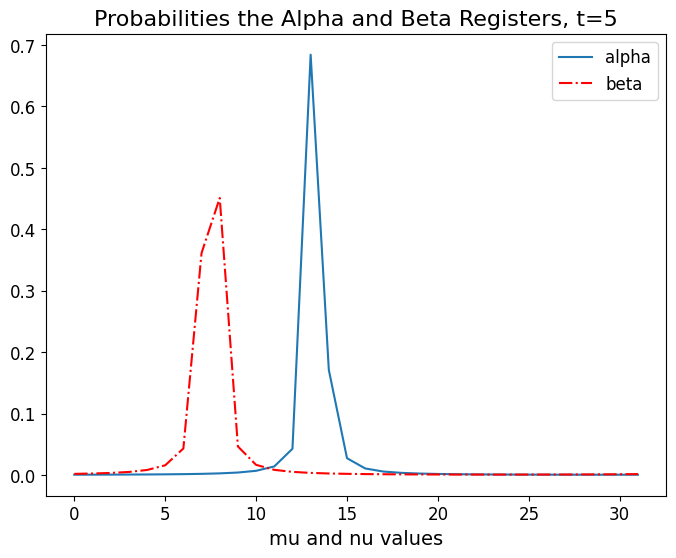

In [18]:
MODULU_NUM = 13
X_LOG_ARG = 3

t = np.ceil(np.log2(ORDER)) + 1
T = 2**t
k = 5
r = ORDER
x_data = np.arange(T)

x0_mu = k * T / r
amplitudes_mu = np.sin(np.pi * (x_data - x0_mu)) / (
    T * np.sin(np.pi * (x_data - x0_mu) / T)
)
probabilities_mu = np.abs(amplitudes_mu) ** 2
probabilities_mu /= np.sum(probabilities_mu)


s = np.log(X_LOG_ARG) / np.log(G_GENERATOR)  # same as log_{G_GENERATOR}(X_LOG_ARG)
x0_nu = s * k * T / r
amplitudes_nu = np.sin(np.pi * (x_data - x0_nu)) / (
    T * np.sin(np.pi * (x_data - x0_nu) / T)
)
probabilities_nu = np.abs(amplitudes_nu) ** 2
probabilities_nu /= np.sum(probabilities_nu)

# Create figure and axis with custom size
fig, ax = plt.subplots(figsize=(8, 6))

# Plot data
ax.plot(x_data, probabilities_mu, label="alpha")
ax.plot(x_data, probabilities_nu, "r-.", label="beta")


# Customize axis labels and title font sizes
ax.set_xlabel("mu and nu values", fontsize=14)
ax.set_ylabel("", fontsize=14)
ax.set_title("Probabilities the Alpha and Beta Registers, t=5", fontsize=16)

# Increase tick label (axis numbers) size
ax.tick_params(axis="both", labelsize=12)


# Show legend
ax.legend(fontsize=12, loc="best")

# Display the plot
plt.show()

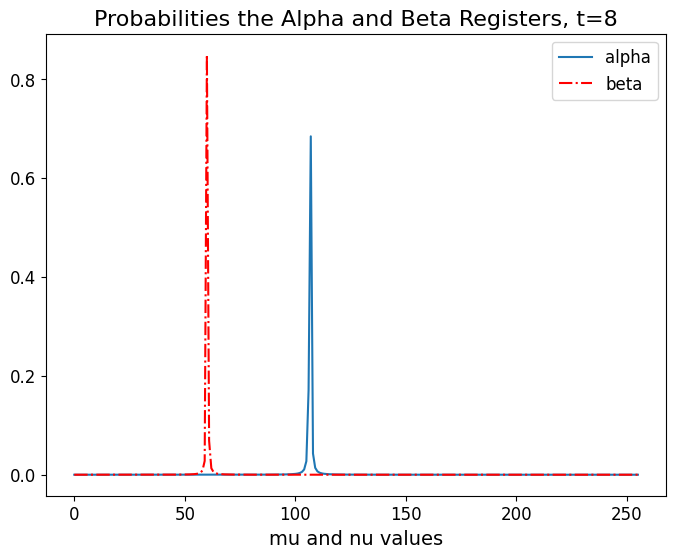

In [19]:
MODULU_NUM = 13
X_LOG_ARG = 3

t = np.ceil(np.log2(ORDER)) + 4
T = 2**t
k = 5
r = ORDER
x_data = np.arange(T)

x0_mu = k * T / r
amplitudes_mu = np.sin(np.pi * (x_data - x0_mu)) / (
    T * np.sin(np.pi * (x_data - x0_mu) / T)
)
probabilities_mu = np.abs(amplitudes_mu) ** 2
probabilities_mu /= np.sum(probabilities_mu)

s = np.log(X_LOG_ARG) / np.log(G_GENERATOR)  # same as log_{G_GENERATOR}(X_LOG_ARG)
x0_nu = s * k * T / r
amplitudes_nu = np.sin(np.pi * (x_data - x0_nu)) / (
    T * np.sin(np.pi * (x_data - x0_nu) / T)
)
probabilities_nu = np.abs(amplitudes_nu) ** 2
probabilities_nu /= np.sum(probabilities_nu)
# Create figure and axis with custom size
fig, ax = plt.subplots(figsize=(8, 6))

# Plot data
ax.plot(x_data, probabilities_mu, label="alpha")
ax.plot(x_data, probabilities_nu, "r-.", label="beta")


# Customize axis labels and title font sizes
ax.set_xlabel("mu and nu values", fontsize=14)
ax.set_ylabel("", fontsize=14)
ax.set_title("Probabilities the Alpha and Beta Registers, t=8", fontsize=16)

# Increase tick label (axis numbers) size
ax.tick_params(axis="both", labelsize=12)


# Show legend
ax.legend(fontsize=12, loc="best")

# Display the plot
plt.show()

## Technical notes

### Equivalence with the Abelian subgroup problem

The discrete logarithm is a specific case of the Hidden Subgroup Problem (HSP) [[4](#HSP)]. The HSP can be stated as follows:

Let $G$ be a group and $H$ is subgroup of $G$. We are given an (oracle) function $f$ with the promise that:
1. $f$ is constant on the right cosets of $H$.
2. Elements of distinct cosets produce different oracle values. That is for $g\in G$ if and only if $x,y\in g H$, $f(x) = f(y)$.
   
Goal: Identify a generating set for the subgroup $H$; that is, a collection of elements of $H$ whose products yield every element of the subgroup.

Note, that there is always a generating set of size $\Omega(\log(|H|))$.

The discrete logarithm problem is an instance of the Abelian HSP.
- $G$ is the additive group $\mathbb{Z}_N\times \mathbb{Z}_N$.
- The hidden subgroup is $ H = \{(0,0), (1,-\log_g x),(2,-2\log_g x,\dots, (r-1,-(r-1)\log_g x))\}$.
- The cosets are the of the form $\{(\alpha, \lambda + \alpha\log_x g)\}$, where $\lambda \in \mathbb{Z}_r$. It is straightforward to show that $f(\alpha,\beta) = g^\lambda$ for all elements of the coset.

Solution of the HSP provides a generator of $(\nu, -\nu\log_g x)$, for $\nu$ coprime to $r$, which allows evaluating the discrete logarithm by taking the modular inverse of $\nu$: $s=-\nu^{-1}\nu \log_g x$.

### Diffie-Hellman Secret Key Sharing Protocol
The Diffie–Hellman protocol enables two parties ("Alice" and "Bob") to establish a shared secret key, and its security against an eavesdropper (“Eve”) relies on the computational hardness of the discrete logarithm problem.

The protocol for sharing a secret key includes the following steps:
1. A prime $p$ and a generator $g$ of a multiplicative group mod $p$, are published publicly.
2. Alice chooses a number $a\in \mathbb{Z}_p$ and computes $A = g^a$. $a$ is known only to Alice.
3. Bob chooses a number $b\in \mathbb{Z}_p$ and computes $B = g^a$. $b$ is known only to Bob.
4. Alice sends Bob a message over a public channel containing $A$, Bob sends Alice a message containing $B$.
5. Alice computes the secret key $ K = B^a = g^{ab}$, and similarly Bob computes the secret key $K=A^b = g^{ab}$.

If the eavesdropper, Eve, can implement the discrete logarithm algorithm, she can evaluate $a=\log_g(A)$ and $b = \log_g(B)$, by intercepting Alice's and Bob's messages, $A$ and $B$. Knowledge of $a$, $b$ and $g$ allows her a straightforward calculation of $K=g^{ab}$.

a## References

<a id='DiscreteLog'>[1]</a>: [Discrete Logarithm (Wikipedia)](https://en.wikipedia.org/wiki/Discrete_logarithm)

<a id='Shor94'>[2]</a>: [Shor, Peter W. "Algorithms for quantum computation: discrete logarithms and factoring." Proceedings 35th annual symposium on foundations of computer science. IEEE, 1994.](https://ieeexplore.ieee.org/abstract/document/365700)

<a id='DiffieHellman'>[3]</a>: [Diffie-Hellman Key Exchange (Wikipedia)](https://en.wikipedia.org/wiki/Diffie%E2%80%93Hellman_key_exchange)

<a id='HSP'>[4]</a>: [Hidden Subgroup Problem (Wikipedia)](https://en.wikipedia.org/wiki/Hidden_subgroup_problem)

<a id='ContinuedFraction'>[5]</a>: [Continued Fraction (Wikipedia)](https://en.wikipedia.org/wiki/Continued_fraction)

<a id='DiscreteLogEllipticCurve'>[6]</a>: [Proos, J., & Zalka, C. (2003). Shor's discrete logarithm quantum algorithm for elliptic curves. arXiv preprint quant-ph/0301141](https://arxiv.org/pdf/quant-ph/0301141)

